# PHYS 641 Assignment 5 
### Andrew V. Zwaniga (260843983)

### Problem 1: WMAP 9-year TT power spectra analysis

The Wilkinson microwave anistropy probe (WMAP) experiment has mapped the temperature anistropies in the cosmic microwave background (CMB) to 13 arcminute resolution after 9 years (2003-2012) of data collection at the second Lagrangian (L2) orbital point for the Earth-Sun system. The TT power spectra data can be obtained in text format in the file named `wmap_tt_spectrum_9yr_v5.txt` which can be found at https://lambda.gsfc.nasa.gov/product/map/dr5/pow_tt_spec_get.cfm. For this exercise, I have deleted the header information in the text file and saved as a new file `WMAP_9r_raw.txt`.

__N.B.:__ TT stands for temperature angular power spectrum. The other power spectra available from LAMBDA are for things like temperature-polarization cross-power spectrum (TE). 

#### Part A: TT power spectra generation from cosmological parameters 

Model power spectra for the CMB can be computed as a function of six input cosmological parameters hereafter designated $\Omega_{b}h^{2}, \Omega_{c}h^{2},n_{s},A_{s},\tau,h$ using Antony Lewis' CAMB code on Lewis' GitHub repository https://github.com/cmbant. Note the following tutorial available for CAMB at https://camb.readthedocs.io/en/latest/CAMBdemo.html. 

__Notation:__ 

(1) $h$ is hereafter known _not_ as Planck's constant but as the Hubble constant. I've never seen this notation before and I find it strange. I am used to $H_{0}$ as the Hubble constant and $H(t)$ as the Hubble parameter for a given epoch: $H_{0}$ is the value of $H(t)$ "today". 

(2) The parameters are defined as follows, as described in the WMAP 9-year data set supplementary explanation paper (https://lambda.gsfc.nasa.gov/product/map/dr5/pub_papers/nineyear/supplement/WMAP_supplement.pdf). 

 - $\Omega_{b}h^{2}$ is the baryonic energy density as a fraction of the critical energy density in the universe, multiplied by the square of the Hubble constant. The units are apparently multiples of proton masses per cubic centimetre, roughly $1.878\times10^{-29}~\text{g}\cdot\text{cm}^{-3}$ 
 - $\Omega_{c}h^{2}$ is the cold dark matter energy density as a fraction of the critical energy density in the universe, multiplied by the square of the Hubble constant. The units are apparently multiples of proton masses per cubic centimetre, roughly $1.878\times10^{-29}~\text{g}\cdot\text{cm}^{-3}$
 - $n_{s}$ is the scalar spectral index; measuring the deviation from unity is part of CMB science programs
 - $A_{s}$ is just a relabelling of what is quoted as $10^{9}\Delta_{\mathcal{R}}^{2}$ though I don't know what this actually is 
 - $\tau$ is the optical depth due to reionization 
 - $h$ is the Hubble constant in $\text{km}\cdot\text{s}^{-1}\cdot\text{Mpc}^{-1}$. 

##### Values for cosmological parameters 

From __Table 3__ in the WMAP 9-year data set the following values will be used to generate a TT power spectrum using `CAMB`: 

- $\Omega_{b}h^{2} = 0.02264$ 
- $\Omega_{c}h^{2} = 0.1138$
- $A_{s} = 2.41\times10^{-9}$
- $n_{s} = 0.972$ 
- $\tau = 0.089$
- $H_{0} = 70.0~\text{km}\cdot\text{s}^{-1}\cdot\text{Mpc}^{-1}$

1198
1198


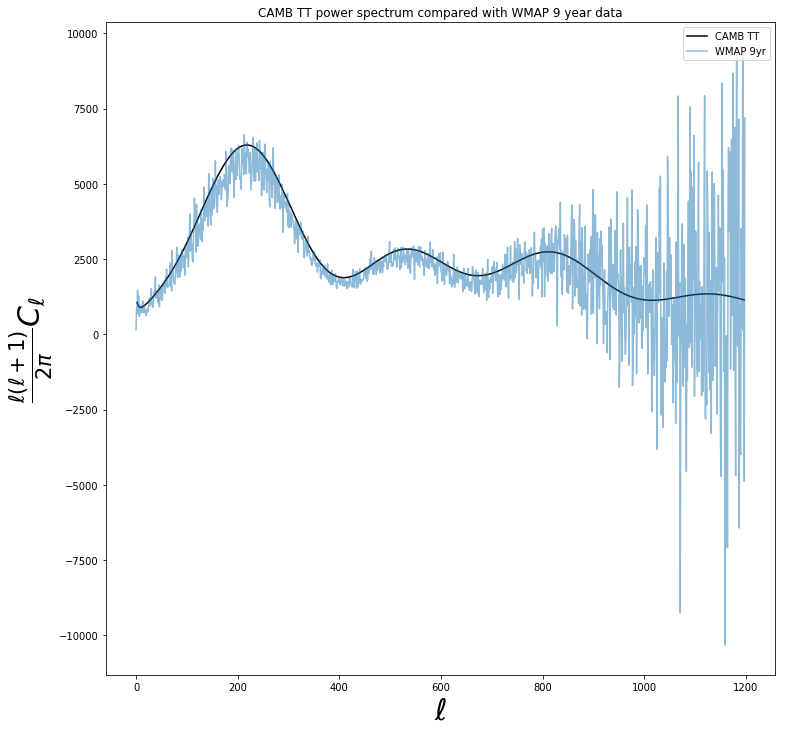

In [6]:
### Part A: Generating a TT power spectrum 
#           using values in WMAP 9-year dataset

import camb 
import numpy as np
from matplotlib import pyplot as plt 
from pylab import *

WMAP = np.loadtxt('WMAP_9yr_raw.txt')


COSMO_DICT = {'ombh2' : -1, 
              'omch2' : -1, 
              'As'    : -1, 
              'ns'    : -1, 
              'tau'   : -1,
              'H0'    : -1}

init_cosmo = {'ombh2' : 0.02264, 
              'omch2' : 0.1138, 
              'As'       : 2.41e-9, 
              'ns'       : 0.972, 
              'tau'      : 0.089,
              'H0'       : 70.0}

## See the CAMB tutorial at https://camb.readthedocs.io/en/latest/CAMBdemo.html
# Use CAMB and the initial parameter values from the WMAP 9-year paper 

params = camb.CAMBparams()
params.set_cosmology(ombh2=init_cosmo['ombh2'], 
                     omch2=init_cosmo['omch2'],
                     tau=init_cosmo['tau'], 
                     H0=init_cosmo['H0'])
params.InitPower.set_params(As=init_cosmo['As'], 
                            ns=init_cosmo['ns'])
results = camb.get_results(params)
pspec   = results.get_cmb_power_spectra(params, CMB_unit='muK')

totCL = pspec['total'][2:1200]
print(totCL.shape[0])
ell = np.arange(totCL.shape[0])
print(len(ell))

# Plot TT angular power spectrum 
# Compare with data in the file `WMAP_9yr_raw.txt`
fig, ax = plt.subplots(1,1, figsize = (12,12))
ax.plot(ell[2:1200], totCL[2:1200,0], color='k',label='CAMB TT')
ax.plot(WMAP[:,1], alpha=0.5, label='WMAP 9yr')
ax.set_title('CAMB TT power spectrum compared with WMAP 9 year data')
ax.set_xlabel('$\ell$',size=30)
ax.set_ylabel('$\\frac{\ell(\ell+1)}{2\pi}C_{\ell}$', size=30)
legend(loc='upper right')


Indeed, the CAMB predicted temperature angular power spectrum is in reasonable agreement with the 9 year data set from WMAP, except the prediction goes to a much higher $l_{\text{max}}$ so we have manually restricted the prediction to have the same range as the data. 

__N.B.__: This is also reflected in the following MCMC code, in that we don't test the data against a prediction that contains information out to a higher $l$. 

#### Part B: Minimizing $\chi^{2}$ by varying a single parameter and holding others constant 

We can produce chains using the MCMC algorithm by holding all parameters constant except for one. Hereafter, these are referred to as __single chains__; the object produced from varying all parameters will be called the __main chain__. The motivation for minimizing with respect to one parameter is this: suppose we start with a guess for the parameters that will globally minimize $chi^{2}$. In principle, how we construct this guess involves only intuition and a priori reasoning. It is likely that starting with $\mathbf{m}_{0}$ will result in a main chain that takes very long to converge. By forming single chains and minimizing $chi^{2}$ with respect to one parameter at a time, we can refine our guess $\mathbf{m}_{0}$ to a new guess $\mathbf{m}_{1}$ that consists of the values of the parameters that minimize $chi^{2}$ when they are allowed to vary and others are held constant. Given enough time, one would continue this process to obtain $\mathbf{m}_{q}$ for some _sufficiently large_ $q$. 

I created a program (see below) called __`WMAP_MCMC.py`__ that can be used for creating both single chains and the main chain, depending on whether a flag called `single_chain` is set to `True` or `False`. 

I produced six single chains, one for each parameter, and saved them in text files: 
 - `ombh2_1Dchain.txt`
 - `omch2_1Dchain.txt`
 - `As_1Dchain.txt`
 - `ns_1Dchain.txt` 
 - `tau_1Dchain.txt`
 - `H0_1Dchain.txt` 
 
Then I created another program called __`analyze_1Dchain.py`__ that reads in the text files above and determines the value of each parameter that minimizes $chi^{2}$. THe minimization procedure is done using linear least squares by fitting a quadratic polynomial $chi^{2}(p) = ap^{2} + bp + c$ to the curve obtained when plotting $chi^{2}$ as a function of the parameter $p$ that is varied. I found the minimizing value $p_{\text{min}}$ and an error estimate as follows: 

$p_{\text{min}} = -\frac{b}{2a},~~~~~~\chi^{2}_{\text{min}} = c - \frac{b^{2}}{4a}$

$\sigma_{p_{\text{min}}} = \frac{1}{2}|[\sigma^{+}_{p_{\text{min}}}+\sigma^{+}_{p_{\text{min}}}]$

with 

$\sigma^{+}_{p_{\text{min}}} = |p_{\text{min}} - p_{+}|,~~~~~~\sigma^{-}_{p_{\text{min}}} = |p_{\text{min}} - p_{-}|$ 

and 

$p_{\pm} = \frac{-b\pm\sqrt{b^{2}-4a[c-(\chi^{2}_{\text{min}}+1)]}}{2a}$ 


In [ ]:
########################################################
#################### WMAP_MCMC.py ######################
########################################################

import camb 
import numpy as np
from matplotlib import pyplot as plt 
from pylab import *

WMAP = np.loadtxt('WMAP_9yr_raw.txt')

NAMES = ['ombh2', 'omch2', 'As', 'ns', 'tau', 'H0'] 

COSMO_DICT = {'ombh2' : -1, 
              'omch2' : -1, 
              'As'    : -1, 
              'ns'    : -1, 
              'tau'   : -1,
              'H0'    : -1}

init_cosmo = {'ombh2'    : 0.02264, 
              'omch2'    : 0.1138, 
              'As'       : 2.41e-9, 
              'ns'       : 0.972, 
              'tau'      : 0.089,
              'H0'       : 70.0}

fitted_cosmo = {'ombh2' : 2.2186e-02, 
                'omch2' : 1.3084e-01, 
                'As'    : 2.2094e-09, 
                'ns'    : 1.0537e+00, 
                'tau'   : 1.3220e-01,
                'H0'    : 7.3391e+01}

BAD_X2    = 10000 # arbitrary  

DEFAULT_ERRORS = COSMO_DICT.copy()
for field in COSMO_DICT:
    DEFAULT_ERRORS[field] = 0 

# hardcoded from running analyze_1Dchain.py 
FITTED_ERRORS = np.asarray([0.00014611622505500237, 0.0007672272103389499, 8.061656432052198e-12, 0.004836234954939567, 0.0017443674831155304, 0.6177621413459846])

#CORR_MATRIX = analyze_MCMC.process_chain(file='chain_10000links.txt') #causes `Segmentation fault: 11` error?

CORR_MATRIX = [[1.,         -0.08430954,  0.2992589,   0.76084872,  0.25088036,  0.4715198],
 [-0.08430954,  1.,          0.11503983, -0.333819,   -0.10541718, -0.82684732,],
 [0.2992589,   0.11503983,  1.,          0.35544301,  0.96779674,  0.04963563,],
 [0.76084872, -0.333819,    0.35544301,  1.,          0.34754604,  0.61534266,],
 [0.25088036, -0.10541718,  0.96779674,  0.34754604,  1.,          0.1898202,],
 [0.4715198,  -0.82684732,  0.04963563,  0.61534266,  0.1898202,   1.,        ]]

#####################################################
# Helper functions 
#####################################################

def update(params, cosmo):
    # Takes in cosmology parameters and new values
    # and returns a parameter set; to be used for 
    # doing chi^2 minimization 
    
    new_params = params.copy() 
    
    new_params.set_cosmology(ombh2=cosmo['ombh2'], 
                             omch2=cosmo['omch2'],
                             H0=cosmo['H0'],
                             tau=cosmo['tau'])
    
    new_params.InitPower.set_params(As=cosmo['As'],
                                    ns=cosmo['ns'])
    return new_params

def get_X2(cosmo, data, params):
    
    # data is passed in WMAP  
    # wmap[:,1] is values, wmap[:,2] is errors 
    
    try: 
        new_params = update(params, cosmo)
        results    = camb.get_results(new_params)
        # IMPORTANT: The WMAP data only goes to lmax = 1200!
        pspec      = results.get_cmb_power_spectra(new_params, CMB_unit='muK')['total']
        
    except: 
        return BAD_X2
    
    indices = np.asarray(data[:,0], dtype='int')
    #print(indices.shape)
    #print(pspec.shape)
    prediction = pspec[indices[2:1200], 0]
    
    X2 = np.sum( (prediction-data[2:1200,1])**2/data[2:1200,2]**2 )
    
    return X2

###########################################################
# Main function 
###########################################################

def make_chain(Nlink=300, single_chain=False, param='ombh2', 
               estimated_errors=FITTED_ERRORS, corr_matrix=CORR_MATRIX, fudge=1.):
    # Nlink is the number of links (steps) in the chain 
    # single_chain is a boolean: if True, only vary 1 param
    # else vary all 
    
    # The initial parameter values that we start with 
    cosmo     = init_cosmo.copy()
    #cosmo     = fitted_cosmo.copy()
    CMBparams = update(camb.CAMBparams(), 
                   cosmo)
    X2_init   = get_X2(cosmo, WMAP, CMBparams)
    
    chains = np.zeros([Nlink, 1 + len(cosmo)])
    
    errors = COSMO_DICT.copy()
    for index, field in enumerate(errors):
        errors[field] = FITTED_ERRORS[index] 

    lam = np.zeros(6) # initialize vector of eigenvalues 
     
    if single_chain == True: 
        # Just vary a single param only 
        # Errors on other params := 0 
        errors[param] = cosmo[param]*0.01 # try a fixed percent for now 
    else: 
        # Vary all parameters using covariance matrix 
        # Use correlated steps: see assignment 2 problem 3 

        lam, C = np.linalg.eigh(corr_matrix) 
        print('---------------------------------')
        print('Eigenvalue decomposition summary:') 
        print('---------------------------------')
        print('Eigenvalues:') 
        print(lam) 
        print('----------------------------------') 
                     
    for link in range(Nlink):

        new_cosmo = init_cosmo.copy() # initialize at each link 
        #new_cosmo = fitted_cosmo.copy() 
   
        if link == 0: 
            X2 = X2_init 

        for index, field in enumerate(COSMO_DICT): 
            if field == 'tau':
                good_tau = False
                while not good_tau: 
                    e = np.random.normal(np.sqrt(lam[index]))
                    new_cosmo[field] = cosmo[field] + errors[field]*e*fudge
                    good_tau = (new_cosmo[field] > 0) 
            else: 
                e = np.random.normal(np.sqrt(lam[index])) 
                new_cosmo[field] = cosmo[field] + errors[field]*e*fudge
                #print('new_cosmo[%s]: %.2e =  %.2e + %.2e*%.4f*%.4f' %(field, new_cosmo[field], cosmo[field], errors[field], e, fudge)) 
            
        new_X2 = get_X2(new_cosmo, WMAP, CMBparams)
        
        accepted = False 
                
        likelihood = -1 

        if new_X2 < BAD_X2:
            upper_rejection_bound = np.exp(-0.5*(new_X2 - X2))
            likelihood = upper_rejection_bound 
            random_fluctuation = np.random.rand()
            #print('Got random fluctuation %.4f' % random_fluctuation)
            #print('Comparing with rejection limit %.4f' % upper_rejection_bound) 
            
            if random_fluctuation < upper_rejection_bound:
                accepted = True 
                
        if accepted: 
            X2    = new_X2
            cosmo = new_cosmo.copy()
        
        if single_chain==True:
            print('%d %.4e %s %.4e' % (link, X2, accepted, cosmo[param]))
        else: 
            print('%d %.4e %s %.4e %.4e %.4e %.4e %.4e %.4e %.4e' % (link, X2, 
                                                                accepted,
                                                                likelihood,
                                                                cosmo[NAMES[0]], 
                                                                cosmo[NAMES[1]], 
                                                                cosmo[NAMES[2]], 
                                                                cosmo[NAMES[3]], 
                                                                cosmo[NAMES[4]], 
                                                                cosmo[NAMES[5]]))
            
        chains[link, 0]  = X2
        chains[link, 1:] = np.asarray(list(cosmo.values()))
    
    return chains

-------------------------------------------
Summary of analysis for ombh2
-------------------------------------------
Percentage of steps accepted: 64.80
Minimized parameter value: 2.2186e-02 +/- 2.0664e-04
Minimized X^2: 1842.9884



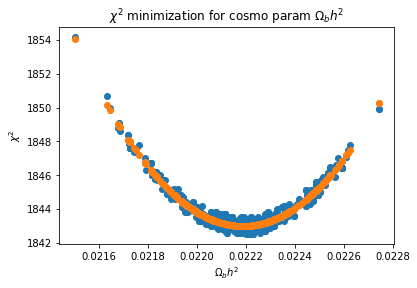

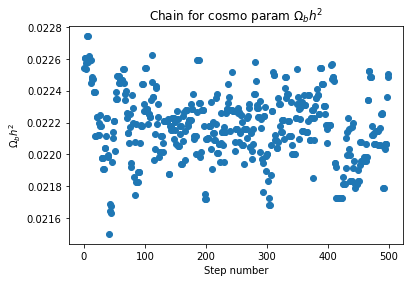

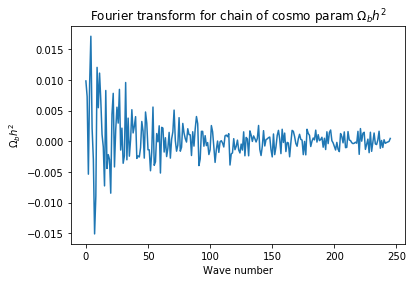

-------------------------------------------
Summary of analysis for omch2
-------------------------------------------
Percentage of steps accepted: 61.80
Minimized parameter value: 1.3084e-01 +/- 7.6723e-04
Minimized X^2: 1342.0480



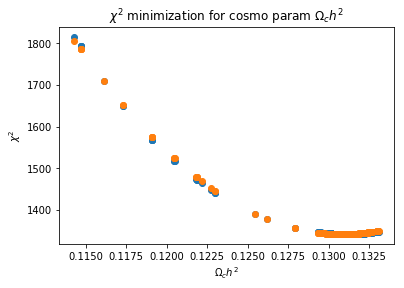

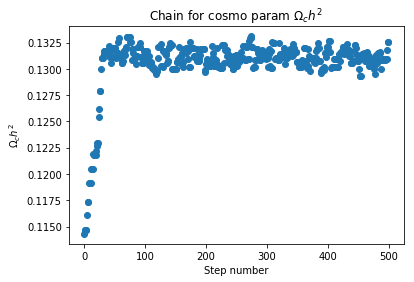

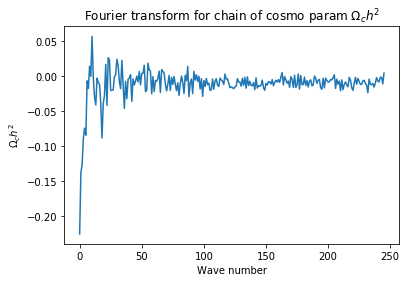

-------------------------------------------
Summary of analysis for As
-------------------------------------------
Percentage of steps accepted: 38.40
Minimized parameter value: 2.2094e-09 +/- 8.0617e-12
Minimized X^2: 1228.6672



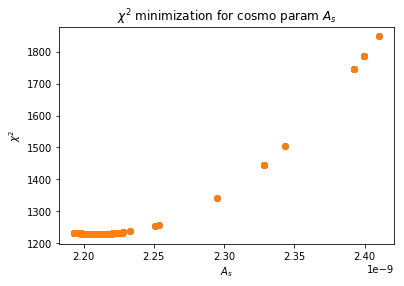

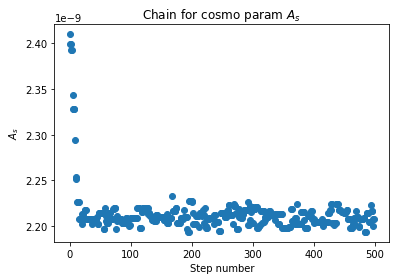

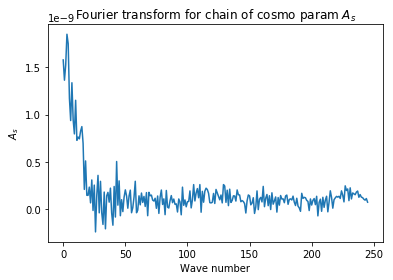

-------------------------------------------
Summary of analysis for ns
-------------------------------------------
Percentage of steps accepted: 50.80
Minimized parameter value: 1.0537e+00 +/- 4.8362e-03
Minimized X^2: 1559.6212



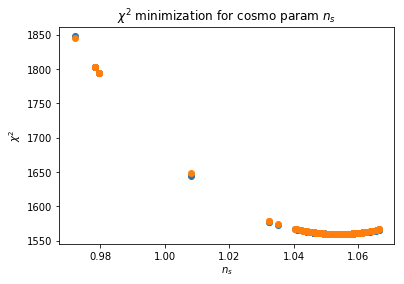

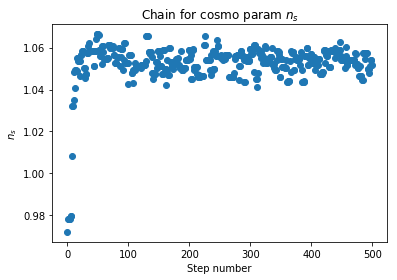

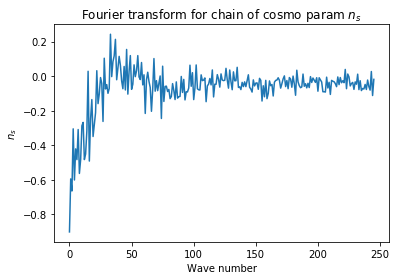

-------------------------------------------
Summary of analysis for tau
-------------------------------------------
Percentage of steps accepted: 75.40
Minimized parameter value: 1.3220e-01 +/- 1.7444e-03
Minimized X^2: 1230.9840



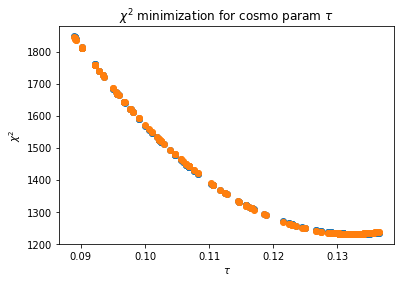

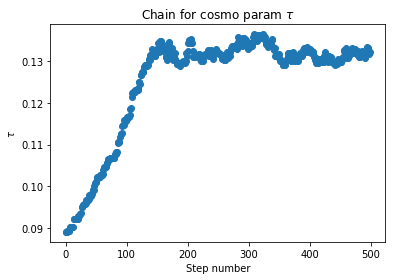

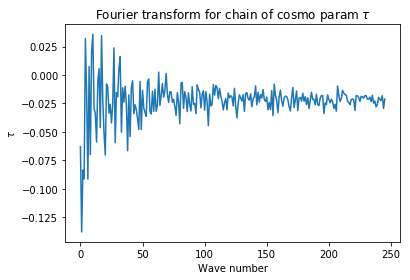

-------------------------------------------
Summary of analysis for H0
-------------------------------------------
Percentage of steps accepted: 62.20
Minimized parameter value: 7.3391e+01 +/- 6.1776e-01
Minimized X^2: 1816.9269



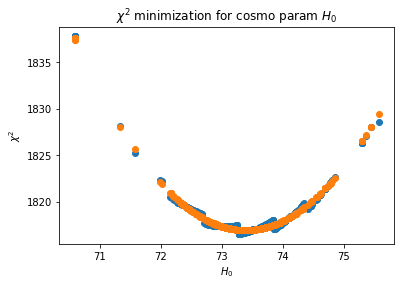

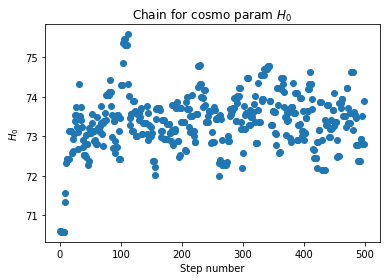

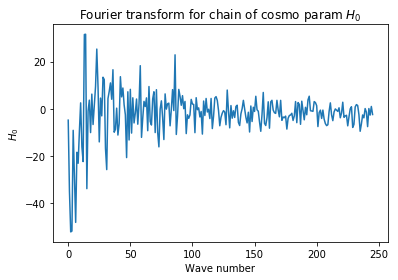

In [20]:
########################################################
################# analyze_1Dchain.py ###################
########################################################

import numpy as np 
import camb 

from matplotlib import pyplot as plt
from pylab import * 

FILE_SUFFIX = '_1Dchain.txt' 
COSMO_NAMES = {'ombh2' : '$\Omega_{b}h^{2}$', 
               'omch2' : '$\Omega_{c}h^{2}$', 
               'As'    : '$A_{s}$', 
               'ns'    : '$n_{s}$', 
               'tau'   : '$\\tau$',
               'H0'    : '$H_{0}$'}
NAMES = ['ombh2', 'omch2', 'As', 'ns', 'tau', 'H0'] 

def process_chain(param, plot=False): 
    # Load a text file containing the chain for a parameter 
    # Fit a quadratic to the chi^2 curve 
    # Calculate an estimate for the error on the parameter 
    # Return this error estimate 

    erorr_estimate = -1

    # Load data 
    filename = param + FILE_SUFFIX
    data_table = np.genfromtxt(filename, delimiter=" ", dtype=None)
    l = data_table.size

    # Pass to local variables 

    links      = np.zeros(l)
    acceptance = np.zeros(l) 
    X2         = np.zeros(l) 
    values     = np.zeros(l) 

    for i in range(l): 
        links[i]      = data_table[i][0] 
        X2[i]         = data_table[i][1] 
        acceptance[i] = float(int(data_table[i][2]))
        values[i]     = data_table[i][3] 

    acc_frac = 100.0*acceptance.sum()/len(acceptance) 

    latex_name = COSMO_NAMES[param]

    # Fit a quadratic polynomial to the chi^2 versus parameter curve 

    degree = 2 # quadratic fit 
    #x = np.linspace(min(values), max(values), l) 
        
    x = values.copy()
    #x.sort() # values is unsorted so gives weird result in fitting 

    A = np.zeros([l, degree+1])
    A[:,0] = 1.0 
    
    for i in range(degree): 
        A[:,i+1] = A[:,i]*x
                    
    At    = A.transpose() 
    AtA   = np.dot(At, A) 
    AtA_i = np.linalg.inv(AtA)  
    m     = np.dot(AtA_i, np.dot(At,X2))
    fit   = np.dot(A, m) 

    a = m[2] 
    b = m[1] 
    c = m[0] 

    sol   = -b/(2*a) # from derivative = 0
    X2min = a*sol**2 + b*sol + c
    
    minus = ((-1)*b-np.sqrt(b**2-4*a*(c-(X2min+1))))/(2*a)
    plus  = ((-1)*b+np.sqrt(b**2-4*a*(c-(X2min+1))))/(2*a)

    minus = np.abs(minus - sol) 
    plus  = np.abs(plus - sol) 

    error_estimate = 0.5*(minus+plus)  

    print('-------------------------------------------') 
    print('Summary of analysis for %s' % param)
    print('-------------------------------------------') 
    print('Percentage of steps accepted: %.2f' % acc_frac)
    print('Minimized parameter value: %.4e +/- %.4e' % (sol, error_estimate))
    print('Minimized X^2: %.4f' % X2min)
    print('') 

    # Plot the chain, chi^2 minimum, and the quadratic polynomial fit 

    if plot == True: 
        plt.figure(1) 
        plt.plot(values, X2, 'o')
        plt.plot(x, fit, 'o') 
        plt.title('$\chi^{2}$ minimization for cosmo param ' + latex_name)
        plt.xlabel(latex_name) 
        plt.ylabel('$\chi^{2}$')
        
        plt.figure(2) 
        plt.plot(links, values, 'o') 
        plt.title('Chain for cosmo param ' + latex_name) 
        plt.xlabel('Step number')
        plt.ylabel(latex_name)
        
        v = values.copy()
        #n = len(v)
        #w = int(n/2)
        #v[w:] = v[w:] - n
        plt.figure(3)
        fft_v = np.real(np.fft.rfft(v))
        plt.plot(fft_v[5:], '-')
        plt.title('Fourier transform for chain of cosmo param ' + latex_name)
        plt.xlabel('Wave number')
        plt.ylabel(latex_name)
        
        plt.show()

    return error_estimate

for field in COSMO_NAMES: 
    process_chain(param=field, plot=True)

#### Remarks about `analyze_1Dchain.py`

One can see that the single chains could have been run longer to obtain more independent samples. Looking at the Fourier transforms of each chain shows that it is not quite white noise exactly. I ran the single chains to 500 steps, but if I had more time I would run them longer.

#### Analyzing the main chain 

After getting the errors on the parameters from $chi^{2}$ minimization for single chains, I used these errors in my program `WMAP_MCMC.py` running in full chain mode i.e. with `single_chain=False`. I tried to use the minimized values that I obtained from my single chain analysis, but these led to a very large $chi^{2}$ starting point for the main chain, and very slow progression towards convergence.. I believe the issue is that my single chains were not converged enough and/or did not contain enough independent samples. Probably by running them longer I would have gotten better minimized values. 

Instead of using those minimized parameter values from the single chain analysis, I decided to keep the estimated errors retrieved from them, but set my initial values in creating the main chain to those values obtained from __Table 3__ in the WMAP 9-year data. 

I created a program called __`analze_MCMC.py`__ to analyze the main chain. The program takes in a text file containing the main chain data and produces three types of plots: 

 - a plot of 2D $\chi^{2}$ surface for each pairing of the parameters 
 - a plot of the power spectrum of each single chain contained in the main chain 
 - a plot of the single chains contained in the main chain 
 
The program outputs some analysis information, including 

 - the fraction of steps that were accepted, as a percentage 
 - the minimum correlation length for each parameter chain 
 - the rough number of independent samples for each chain 
 - the correlation matrix for the six parameters 

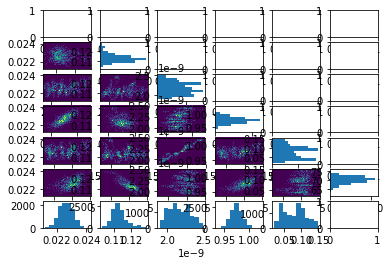

Acceptance percentage: 36.5800
Statistics for ombh2: 2.2650e-02 +/- 4.6134e-04 with corr len 224.0000 and approx. 44.6429 indep. samples
Statistics for omch2: 1.1309e-01 +/- 4.3106e-03 with corr len 555.0000 and approx. 18.0180 indep. samples
Statistics for As: 2.1693e-09 +/- 1.4475e-10 with corr len 2516.0000 and approx. 3.9746 indep. samples
Statistics for ns: 9.7529e-01 +/- 1.2042e-02 with corr len 726.0000 and approx. 13.7741 indep. samples
Statistics for tau: 7.9678e-02 +/- 3.2310e-02 with corr len 2424.0000 and approx. 4.1254 indep. samples
Statistics for H0: 6.9942e+01 +/- 1.9381e+00 with corr len 594.0000 and approx. 16.8350 indep. samples
The correlation matrix is
[[ 1.         -0.08430954  0.2992589   0.76084872  0.25088036  0.4715198 ]
 [-0.08430954  1.          0.11503983 -0.333819   -0.10541718 -0.82684732]
 [ 0.2992589   0.11503983  1.          0.35544301  0.96779674  0.04963563]
 [ 0.76084872 -0.333819    0.35544301  1.          0.34754604  0.61534266]
 [ 0.25088036 -0.1

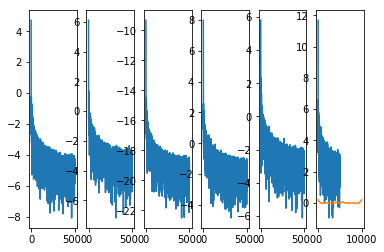

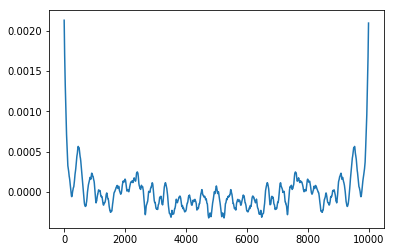

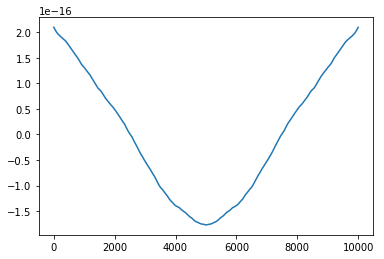

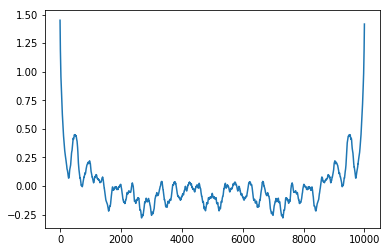

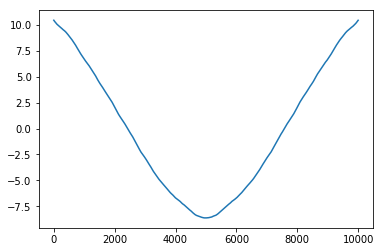

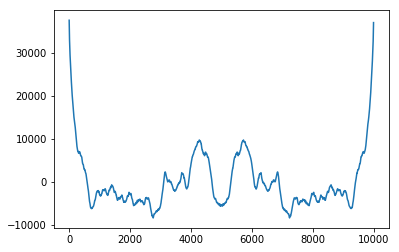

array([[ 1.        , -0.08430954,  0.2992589 ,  0.76084872,  0.25088036,
         0.4715198 ],
       [-0.08430954,  1.        ,  0.11503983, -0.333819  , -0.10541718,
        -0.82684732],
       [ 0.2992589 ,  0.11503983,  1.        ,  0.35544301,  0.96779674,
         0.04963563],
       [ 0.76084872, -0.333819  ,  0.35544301,  1.        ,  0.34754604,
         0.61534266],
       [ 0.25088036, -0.10541718,  0.96779674,  0.34754604,  1.        ,
         0.1898202 ],
       [ 0.4715198 , -0.82684732,  0.04963563,  0.61534266,  0.1898202 ,
         1.        ]])

In [21]:
###################################################################
######################## analyze_MCMC.py ##########################
###################################################################

import numpy as np
import camb

from matplotlib import pyplot as plt
from pylab import *

FILE_SUFFIX = '_1Dchain.txt'
COSMO_NAMES = {'ombh2' : '$\Omega_{b}h^{2}$',
               'omch2' : '$\Omega_{c}h^{2}$',
               'As'    : '$A_{s}$',
               'ns'    : '$n_{s}$',
               'tau'   : '$\\tau$',
               'H0'    : '$H_{0}$'}
NAMES = ['ombh2', 'omch2', 'As', 'ns', 'tau', 'H0']

FITTED_ERRORS = [0.00014611622505500237, 0.0007672272103389499, 8.061656432052198e-12, 0.004836234954939567, 0.0017443674831155304, 0.6177621413459846] 

def process_chain(file='', X2plots=False, PSplots=False, CORRplot=False, nbins=50):
    
    data_table = np.genfromtxt(file, delimiter=' ', dtype=None)
    l = data_table.size
    m = len(NAMES)

    links      = np.zeros([l,1])
    acceptance = np.zeros([l,1])
    X2         = np.zeros([l,1])
    likelihood = np.zeros([l,1])
    values     = np.zeros([l,m])

    for i in range(l):
        links[i]      = data_table[i][0] 
        X2[i]         = data_table[i][1] 
        acceptance[i] = float(int(data_table[i][2]))
        likelihood[i] = data_table[i][3] 
        for j in range(m):
            values[i,j]     = data_table[i][4+j] 
        
    # Plot each parameter against each other parameter 

    if X2plots == True:
        fig, ax = plt.subplots(nrows=m+1, ncols=m) 
        for j in range(m+1):
                for k in range(m):                     
                    # row j, column k 
                    if j < m: 
                        latex_xaxis = COSMO_NAMES[NAMES[j]]            
                        if k < j: 
                            # only plot lower diagonal since symmetric
                            latex_yaxis = COSMO_NAMES[NAMES[k]]
                            #ax[j,k].plot(values[:,j], values[:,k], '*',color='black')                       
                            ax[j,k].hist2d(values[:,j], values[:,k], bins = nbins) 
                        if k == j and k > 0: 
                            # On the diagonal, plot hist of y-axis variable 
                            ax[j,k].hist(values[:,k],orientation='horizontal')
                    else:  
                        if k < j-1: 
                            # add bottom row for histograms 
                            ax[j,k].hist(values[:,k],orientation='vertical')
        plt.show()

    # Caluclate acceptance fraction of steps 
        
    acc = 100.*acceptance.sum()/len(acceptance)
    print('Acceptance percentage: %.4f' % acc) 

    # Plot the chain followed by power spectrum of each chain 

    ps = []
    
    if PSplots == True:
        fig, ax = plt.subplots(nrows=1,ncols=m)
        for j in range(m):
            ps.append(np.abs((np.fft.rfft(values[:,j]))**2))
            ax[j].plot(np.log10(ps[j])) 
            #plt.title('Power spectrum for ' + COSMO_NAMES[NAMES[j]]) 
            #plt.xlabel('$k$') 
            #plt.ylabel('Power') 

    # Calcuate mean, standard deviation, FFT, correlation matrix 
    
    norm_vals = values.copy()

    for j in range(m): 
        # For each parameter 
        data        = values[:,j].copy()
        mu          = np.mean(data) 
        sigma       = np.std(data)  
        data        = data - mu  # subtract the mean 
        ft_data     = np.fft.rfft(data) 
        correlation = np.fft.irfft(ft_data*np.conj(ft_data))
        if CORRplot == True:
            plt.figure(j)
            plt.plot(correlation)
            corr_len    = np.min(np.where(correlation<0))
            num_indep   = len(data)/corr_len
            print('Statistics for %s: %.4e +/- %.4e with corr len %.4f and approx. %.4f indep. samples' 
                  % (NAMES[j], mu, sigma, corr_len, num_indep))
            norm_vals[:,j] = norm_vals[:,j] - norm_vals[:,j].mean()
            norm_vals[:,j] = norm_vals[:,j]/norm_vals[:,j].std()
            corr_matrix    = np.dot(norm_vals.transpose(),norm_vals)/norm_vals.shape[0] 
            
            
    print('The correlation matrix is') 
    print(corr_matrix)

    plt.show()    
    return corr_matrix

process_chain(file='chain_10000links.txt', X2plots=True, PSplots=True, CORRplot=True)


### Part C: 

I used my program `WMAP_MCMC.py` to produce a main chain of 10,000 steps and then I used my other program `analyze_MCMC.py` to produce a correlation matrix from this main chain (see above). 

With the correlation matrix in hand, I fed this into my program `WMAP_MCMC.py` and computed the eigenvalue decomposition of the matrix as we did on __problem 3 assignment 2__ in order to obtain the eigenvalues. Using these six eigenvalues, I generated correlated steps as follows: I used the estimated errors I found from single chain analysis as steps but modulated by a random number pulled fro a Gaussian normal distribution with $\sigma = \sqrt{\lambda}$ where $\lambda$ is the eigenvalue for that parameter from the eigenvalue decomposition of the correlation matrix. 

I then used `WMAP_MCMC.py` to run some short chains and varying the parameter called `fudge` which allows the step sizes to be modified by a fudge factor. I tried a few different values to see what the acceptance was and what the correlation lengths were. I found that the acceptance seemed to be inversely proportional to the `fudge` value. I  tried `fudge` values in the range $\{1, 0.3, 0.2, 0.15, 0.1\}$ and found corresponding acceptances $\{6.3\%, 16.3\%, 22.0\%, 28.3\%, 38.3\%\}$ when running chains of length 300. [__N.B.__ These acceptance percentages change dramatically when the chain length is increased.]

I selected `fudge=0.125` and ran a chain of length 3,000 to see if taking correlated steps would improve the convergence of the main chain. I found strange results which I don't fully understand. It seems that the steps are always taken so that __all__ parameters are increased, so that in the limit of waiting for a long number of steps the value of $\chi^{2}$ continues to increase. Looking at the $\chi^{2}$ landscapes again seems to reveal this behaviour. 

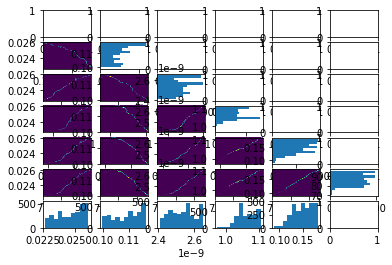

Acceptance percentage: 12.5292
Statistics for ombh2: 2.4609e-02 +/- 9.7477e-04 with corr len 654.0000 and approx. 4.5887 indep. samples
Statistics for omch2: 1.0941e-01 +/- 5.1328e-03 with corr len 642.0000 and approx. 4.6745 indep. samples
Statistics for As: 2.5366e-09 +/- 6.7286e-11 with corr len 621.0000 and approx. 4.8325 indep. samples
Statistics for ns: 1.0614e+00 +/- 2.6763e-02 with corr len 620.0000 and approx. 4.8403 indep. samples
Statistics for tau: 1.5062e-01 +/- 2.0649e-02 with corr len 636.0000 and approx. 4.7186 indep. samples
Statistics for H0: 8.6810e+01 +/- 5.6497e+00 with corr len 621.0000 and approx. 4.8325 indep. samples
The correlation matrix is
[[ 1.         -0.95553654  0.98841969  0.96944954  0.98968126  0.9856722 ]
 [-0.95553654  1.         -0.98148371 -0.95823354 -0.95612695 -0.96601875]
 [ 0.98841969 -0.98148371  1.          0.98153422  0.98789967  0.99228746]
 [ 0.96944954 -0.95823354  0.98153422  1.          0.98942735  0.99411186]
 [ 0.98968126 -0.9561269

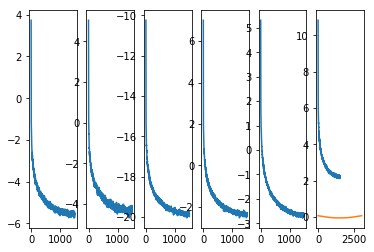

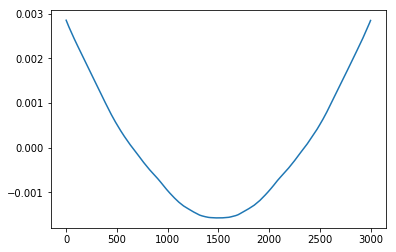

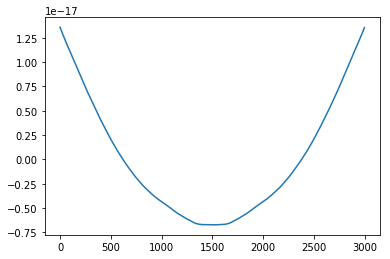

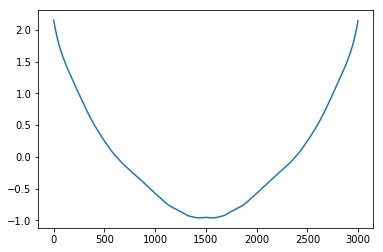

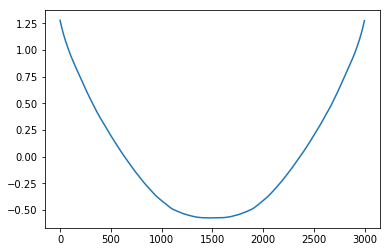

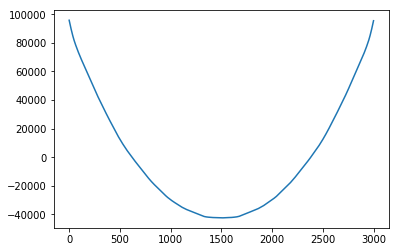

array([[ 1.        , -0.95553654,  0.98841969,  0.96944954,  0.98968126,
         0.9856722 ],
       [-0.95553654,  1.        , -0.98148371, -0.95823354, -0.95612695,
        -0.96601875],
       [ 0.98841969, -0.98148371,  1.        ,  0.98153422,  0.98789967,
         0.99228746],
       [ 0.96944954, -0.95823354,  0.98153422,  1.        ,  0.98942735,
         0.99411186],
       [ 0.98968126, -0.95612695,  0.98789967,  0.98942735,  1.        ,
         0.99725431],
       [ 0.9856722 , -0.96601875,  0.99228746,  0.99411186,  0.99725431,
         1.        ]])

In [22]:
process_chain(file='chain_3000_corr_0125.txt', X2plots=True, PSplots=True, CORRplot=True)

For the sake of completeness, I am going to quote the results I get from the non-correlated steps method, since I get many more independent samples there and the values seem much more reasonable in comparison with what WMAP reports for the cosmological parameters. I get 

 - $\Omega_{b}h^{2} = (2.265 \pm 0.046)\times10^{-2}$
 - $\Omega_{c}h^{2} = (1.131 \pm 0.043)\times10^{-1}$
 - $A_{s} = (2.17 \pm 0.14)\times10^{-9} $
 - $n_{s} = (9.75 \pm 0.12)\times10^{-1}$
 - $\tau = (8.0 \pm 3.2)\times10^{-2}$
 - $H_{0} = (6.99 \pm 0.19)\times10^{1}~\text{km}~\text{s}^{-1}~\text{Mpc}^{-1}$